In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['class'] = cancer.target

df.tail()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,...,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,1


# Convert to pytorch tensor

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
data = torch.from_numpy(df.values).float() # make double to float
data.shape

torch.Size([569, 31])

In [4]:
# 일부만 사용
x = data[:, :10]
y = data[:, -1:]

print(x.shape, y.shape)

torch.Size([569, 10]) torch.Size([569, 1])


In [5]:
# Train / Valid / Test ratio
ratios = [.6, .2, .2]

In [6]:
train_cnt = int(data.size(0)*ratios[0])
valid_cnt = int(data.size(0)*ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt

cnts = [train_cnt, valid_cnt, test_cnt]
print(cnts)

[341, 113, 115]


In [7]:
indices = torch.randperm(data.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = x.split(cnts, dim=0)
y = y.split(cnts, dim=0)

for x_i, y_i in zip(x,y):
    print(x_i.size(), y_i.size())

torch.Size([341, 10]) torch.Size([341, 1])
torch.Size([113, 10]) torch.Size([113, 1])
torch.Size([115, 10]) torch.Size([115, 1])


# Set hyper parameter

In [8]:
n_epochs = 5000
batch_size = 128
print_interval = 100
early_stop = 500

# Dataloaders

In [9]:
from torch.utils.data import DataLoader, Dataset

In [10]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y
                
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
train_loader = DataLoader(
    dataset=MyDataset(x[0],y[0]),
    batch_size=batch_size,
    shuffle=True)
valid_loader = DataLoader(
    dataset=MyDataset(x[1],y[1]),
    batch_size=batch_size,
    shuffle=False)
test_loader = DataLoader(
    dataset=MyDataset(x[2],y[2]),
    batch_size=batch_size,
    shuffle=False)

In [12]:
model = nn.Sequential(
    nn.Linear(x[0].size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y[0].size(-1)),
    nn.Sigmoid(),
)

model

Sequential(
  (0): Linear(in_features=10, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
  (9): Sigmoid()
)

## Use GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
model = model.to(device)
optimizer = optim.Adam(model.parameters())

# Train

In [15]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None
lowest_epoch = np.inf

In [16]:
train_history, valid_history = [], []

for i in range(n_epochs):
    model.train()
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    for x_i, y_i in train_loader:
        x_i = x_i.to(device)
        y_i = y_i.to(device)
        y_hat_i = model(x_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        train_loss += float(loss)
    train_loss = train_loss / len(train_loader)
    
    model.eval()
    with torch.no_grad():
        for x_i, y_i in valid_loader:
            x_i = x_i.to(device)
            y_i = y_i.to(device)
            y_hat_i = model(x_i)
            loss = F.binary_cross_entropy(y_hat_i, y_i)
            valid_loss += float(loss)
    valid_loss = valid_loss / len(valid_loader)
    
    train_history += [train_loss]
    valid_history += [valid_loss]
    
    if (i+1) % print_interval == 0:
        print(f'Epoch{i+1}, train_loss={train_loss}, val_loss={valid_loss}')
    if valid_loss < lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print(f'There is no improvement during last {early_stop} epochs')
            break
            
print(f'The best validation loss from epoch {lowest_epoch}')
model.load_state_dict(best_model)

Epoch100, train_loss=0.5970321893692017, val_loss=0.6094043254852295
Epoch200, train_loss=0.38508370518684387, val_loss=0.31410783529281616
Epoch300, train_loss=0.3545889655749003, val_loss=0.2786180078983307
Epoch400, train_loss=0.3368729551633199, val_loss=0.268086701631546
Epoch500, train_loss=0.3411948283513387, val_loss=0.26400673389434814
Epoch600, train_loss=0.32961999376614887, val_loss=0.26187941431999207
Epoch700, train_loss=0.3164640466372172, val_loss=0.25874146819114685
Epoch800, train_loss=0.3102673391501109, val_loss=0.24575357139110565
Epoch900, train_loss=0.30527958273887634, val_loss=0.2385483980178833
Epoch1000, train_loss=0.29121694962183636, val_loss=0.2394839972257614
Epoch1100, train_loss=0.2893600861231486, val_loss=0.2353561818599701
Epoch1200, train_loss=0.27746185660362244, val_loss=0.23835724592208862
Epoch1300, train_loss=0.27192142605781555, val_loss=0.23204591870307922
Epoch1400, train_loss=0.2699013203382492, val_loss=0.23211602866649628
Epoch1500, train

<All keys matched successfully>

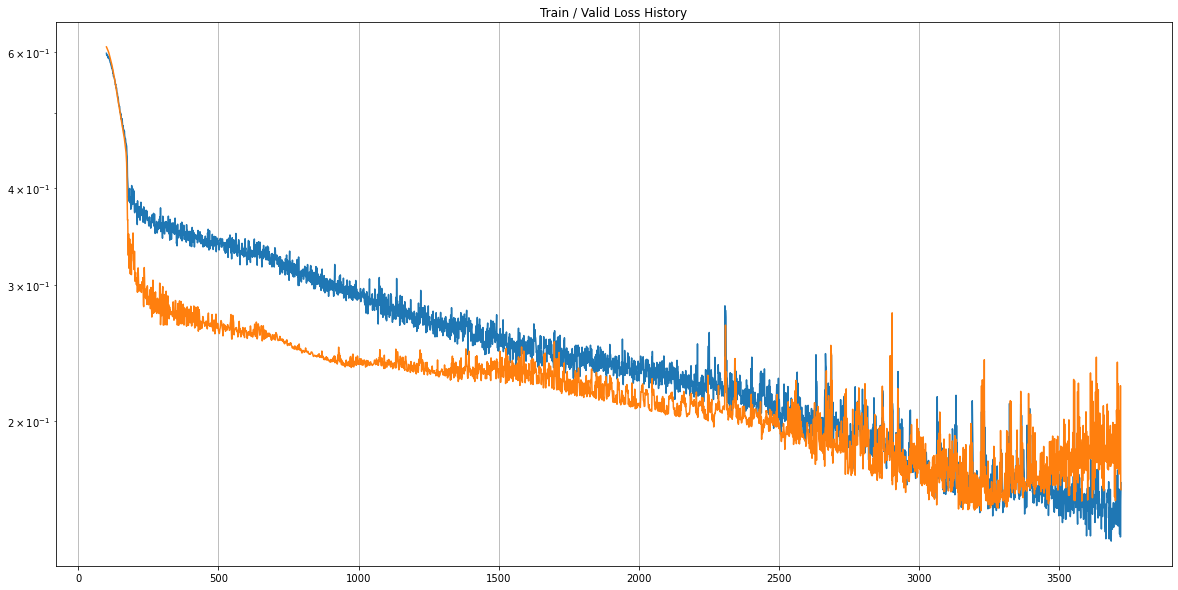

In [17]:
plot_from = 100

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

# test

In [18]:
test_loss = 0
y_hat = []

model.eval()
with torch.no_grad():
    for x_i, y_i in test_loader:
        x_i = x_i.to(device)
        y_i = y_i.to(device)
        y_hat_i = model(x_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)

        test_loss += loss # Gradient is already detached.

        y_hat += [y_hat_i]

test_loss = test_loss / len(test_loader)
y_hat = torch.cat(y_hat, dim=0)

print(f"Test loss: {test_loss}")

Test loss: 0.13563072681427002


In [19]:
y[2].shape

torch.Size([115, 1])

In [21]:
correct_cnt = (y[2] == (y_hat.to('cpu') > .5)).sum()
total_cnt = float(y[2].size(0))
acc = correct_cnt / total_cnt
print(f'Test Accuracy: {acc}')

Test Accuracy: 0.939130425453186
